# Assignment 2
* Name: Yeongu Choe
* Student number: 77672566

In [1]:
from PIL import Image, ImageDraw
import numpy as np
import math
from scipy import signal, ndimage
import ncc

## Part1: Face detection

### 2. MakeGaussianPyramid(image:Image.Image, scale:float, minsize:int)->[np.array]

In [2]:
def MakeGaussianPyramid(image: str, scale: float, minsize: int) -> [np.array]:
    # Step1: Make image instance
    imageInstance = Image.open(image).convert('RGB')

    # Step2: Initialize Gaussian pyramid
    GaussianPyramid = []

    # Step3: Split RGB channel
    RedChannel, GreenChannel, BlueChannel = imageInstance.split()

    # Step4: Make channels into np array
    RedChannel = np.asarray(RedChannel)
    GreenChannel = np.asarray(GreenChannel)
    BlueChannel = np.asarray(BlueChannel)

    # Step5: Get height and width
    height = RedChannel.shape[0]
    width = RedChannel.shape[1]

    # Step6: Append the first image
    GaussianPyramid.append([RedChannel, GreenChannel, BlueChannel])

    # Step7: sigma  1/(2*scale)
    std = 1/(2*scale)

    while (RedChannel.shape[0] > minsize and RedChannel.shape[1] > minsize):
        # Step8: Gaussian Blur image
        RedChannel = ndimage.gaussian_filter(RedChannel, sigma=std)
        GreenChannel = ndimage.gaussian_filter(GreenChannel, sigma=std)
        BlueChannel = ndimage.gaussian_filter(BlueChannel, sigma=std)
        # current data type: numpy.ndarray

        # Step9: convert back to image
        RedChannel = Image.fromarray(RedChannel)
        GreenChannel = Image.fromarray(GreenChannel)
        BlueChannel = Image.fromarray(BlueChannel)
        # current data type: PIL.Image.Image

        # Step10: resize
        width = RedChannel.size[0]
        height = RedChannel.size[1]
        RedChannel = RedChannel.resize(
            (int(width*scale), int(height*scale)), Image.BICUBIC)
        GreenChannel = GreenChannel.resize(
            (int(width*scale), int(height*scale)), Image.BICUBIC)
        BlueChannel = BlueChannel.resize(
            (int(width*scale), int(height*scale)), Image.BICUBIC)
        # current data type: PIL.Image.Image

        # Step11 convert back to numpy array
        RedChannel = np.asarray(RedChannel)
        GreenChannel = np.asarray(GreenChannel)
        BlueChannel = np.asarray(BlueChannel)
        # current data type: numpy.ndarray

        # Step12: append to Gaussian pyramid list
        GaussianPyramid.append([RedChannel, GreenChannel, BlueChannel])

    return GaussianPyramid


judybatsPyramid = MakeGaussianPyramid("Image/Part1/judybats.jpg", 0.75, 1)

### 3. ShowGaussianPyramid(pyramid:list[[np.array,np.array,np.array]])->none

In [3]:
def showGaussianPyramid(pyramid):
    # Step1: finding the dimension output image
    outputWidth = 0
    for i in range(len(pyramid)):
        outputWidth += pyramid[i][0].shape[1]
    outputHeight = pyramid[0][0].shape[0]

    # Step2: create new image instance
    newImage = Image.new('RGB', (outputWidth, outputHeight))

    # Step3: make the image white space
    newImage.paste((255, 255, 255), (0, 0, outputWidth, outputHeight))

    # Step4: paste images
    currentWidth = 0
    numberOfImage = len(pyramid)
    for i in range(numberOfImage):
        # Step5: convert into RGB image
        Redchannel = Image.fromarray(pyramid[i][0]).convert('L')
        Greenchannel = Image.fromarray(pyramid[i][1]).convert('L')
        Bluechannel = Image.fromarray(pyramid[i][2]).convert('L')
        # current data type: PIL.Image.Image
        # black and white image

        # Step6: merge 'L' image into one 'RGB' image
        mergedImage = Image.merge(
            'RGB', (Redchannel, Greenchannel, Bluechannel))
        # Step7: paste image
        im_width = mergedImage.width
        newImage.paste(mergedImage, (currentWidth,
                       (outputHeight - mergedImage.height)//2))
        # Step8: update starting position
        currentWidth += im_width
    return newImage

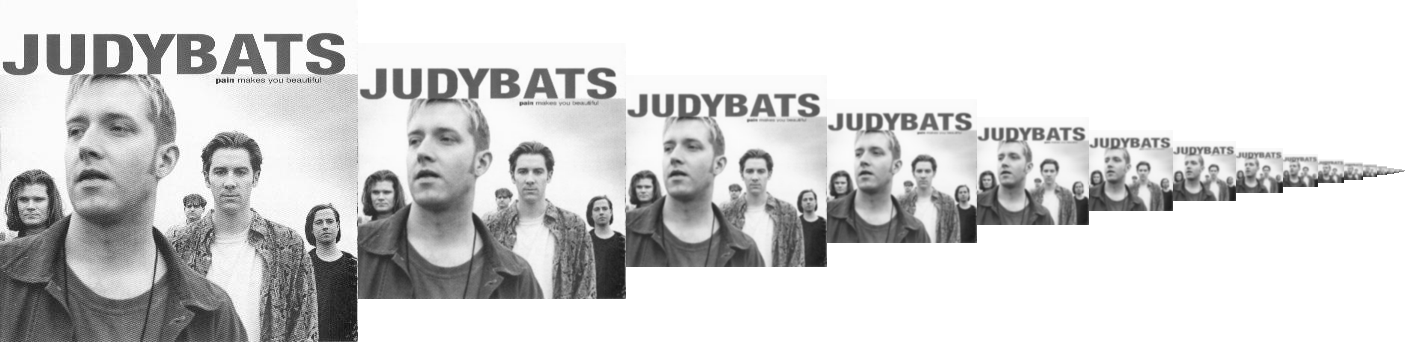

In [4]:
# Judybats Gaussian Pyramid
judybatPyramidImage = showGaussianPyramid(judybatsPyramid)
# judybatPyramidImage.show()
judybatPyramidImage

### 4. FindTemplate(pyramid, template, threshold)
* Function to detect template from a image (pyramid[0])

In [5]:
def FindTemplate(pyramid: [[np.array, np.array, np.array]], template: str, threshold: float):
    # Step1: Open template image and convert to greyscale
    templateInstance = Image.open(template).convert('L')

    # Step2: Resize template have width 15px
    templateWidth = templateInstance.size[0]
    templateHeight = templateInstance.size[1]

    # Step3: Decision to make resizing
    wantResize = True
    if (wantResize):
        newTemplateWidth = 15
        newTemplateHeight = (newTemplateWidth*templateHeight)//templateWidth
        templateInstance = templateInstance.resize(
            (newTemplateWidth, newTemplateHeight), Image.BICUBIC)

    # Step4: Create list of tuples that will contain every found corrdinates
    # List of tuples
    # Each tuple represent found pixel coordinate
    everyFoundCoord = []

    for i in range(len(pyramid)):
        # Step5: Run NCC on image
        # Open image in three greyscale, each representing RGB channels
        redImage = Image.fromarray(pyramid[i][0]).convert('L')
        greenImage = Image.fromarray(pyramid[i][1]).convert('L')
        blueImage = Image.fromarray(pyramid[i][2]).convert('L')

        # Step6: Convert image into RGB image
        imageInstance = Image.merge('RGB', (redImage, greenImage, blueImage))

        # Step7: Convert image instance into greyscale image
        imageInstance = imageInstance.convert('L')

        # Step8: Convert Image and template into numpy array
        imageInstance = np.asarray(imageInstance)
        templateInstance = np.asarray(templateInstance)

        # Step9: run ncc function
        nccResult = ncc.normxcorr2D(imageInstance, templateInstance)

        # Step10: only extract pixels above threshold

        conditioned = np.where(nccResult > threshold)
        foundSpots = list(zip(conditioned[0], conditioned[1]))
        # Step11: convert list of pairs back to original scale
        scaleToBecomeOriginalCoordinate = 0.75**i
        for coord in foundSpots:
            coord_originalImage = (
                coord[0]//scaleToBecomeOriginalCoordinate, coord[1]//scaleToBecomeOriginalCoordinate)
            everyFoundCoord.append(coord_originalImage)

    # Draw box around found coordinates
    # Step12: calculate half width and height
    halfWidth = templateWidth//2
    halfHeight = templateHeight//2

    # Step13: Create original image from pyramid
    r = Image.fromarray(pyramid[0][0]).convert('L')
    g = Image.fromarray(pyramid[0][1]).convert('L')
    b = Image.fromarray(pyramid[0][2]).convert('L')

    # Step14: Convert image into RGB image
    originalImageInstance = Image.merge('RGB', (r, g, b))

    # Step15: instantiate drawing
    drawing = ImageDraw.Draw(originalImageInstance)
    for foundPoint in everyFoundCoord:
        rowNumber = foundPoint[0]
        columnNumber = foundPoint[1]
        drawing.line((columnNumber-halfWidth, rowNumber-halfHeight, columnNumber -
                     halfWidth, rowNumber+halfHeight), fill="red", width=2)  # left vertical line
        drawing.line((columnNumber-halfWidth, rowNumber-halfHeight, columnNumber +
                     halfWidth, rowNumber-halfHeight), fill="red", width=2)  # top horizontal line
        drawing.line((columnNumber+halfWidth, rowNumber-halfHeight,
                     columnNumber+halfWidth, rowNumber+halfHeight), fill="red", width=2)  # right vertical line
        drawing.line((columnNumber-halfWidth, rowNumber+halfHeight, columnNumber+halfWidth,
                     rowNumber+halfHeight), fill="red", width=2)  # bottom horizontal line
    return originalImageInstance

/Users/yeonguchoe/Desktop/CPSC-425/Assignment/Assignment2/ncc.py:60: RuntimeWarning: divide by zero encountered in divide
  nxcorr = np.where(denom < tol, 0, numer/denom)


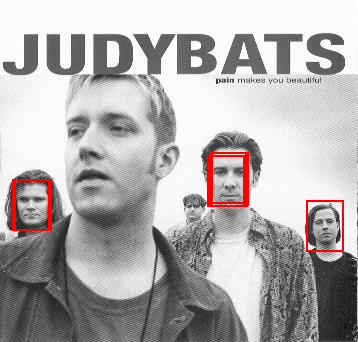

In [6]:
# Finding face template from judybats image
faceDetectionFromJudybats = FindTemplate(
    judybatsPyramid, "Image/Part1/template.jpg", 0.74)
# faceDetectionFromJudybats.show()
faceDetectionFromJudybats

### 5. Run template matching in judybats, students, tree, family, fans, sports
* Find good threshold that makes $N(\text{False positive}) == N(\text{False negative})$
* **False positive**: detected template but it is not a face
* **False negative**: not detected where those are actually face

|Image|False positive|False negative|
|--|---|---|
|judybats|2|1|
|students|2|4|
|tree|2|0|
|family|0|1|
|fans|2|2|
|sports|1|1|

Good threshold is 0.6.


In [7]:
goodThreshold = 0.6

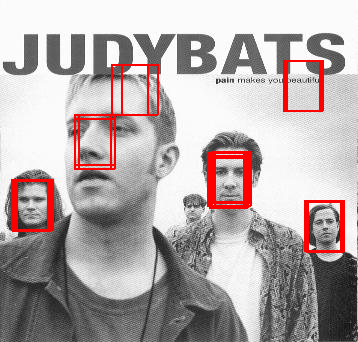

In [8]:
# judybats
judybatsPyramid = MakeGaussianPyramid("Image/Part1/judybats.jpg", 0.75, 30)
FindTemplate(judybatsPyramid, "Image/Part1/template.jpg", goodThreshold)

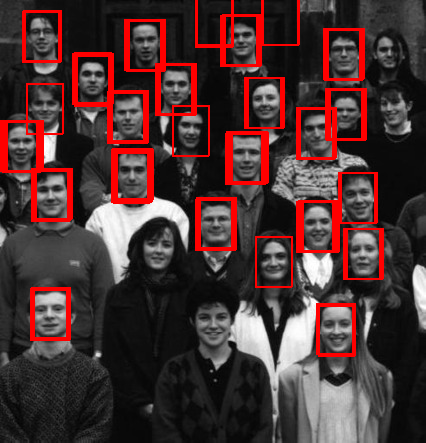

In [9]:
# students
studentsPyramid = MakeGaussianPyramid("Image/Part1/students.jpg", 0.75, 30)
FindTemplate(studentsPyramid,"Image/Part1/template.jpg",goodThreshold)

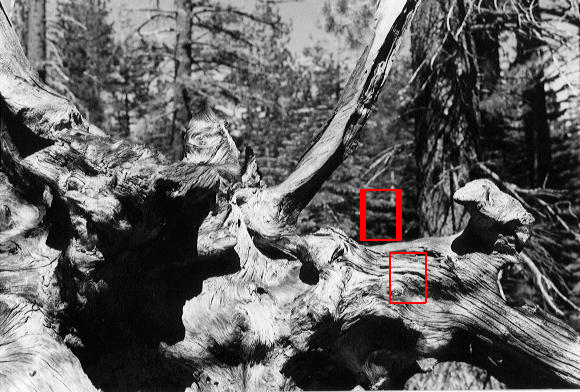

In [10]:
# tree
treePyramid = MakeGaussianPyramid("Image/Part1/tree.jpg", 0.75, 30)
FindTemplate(treePyramid,"Image/Part1/template.jpg",goodThreshold)

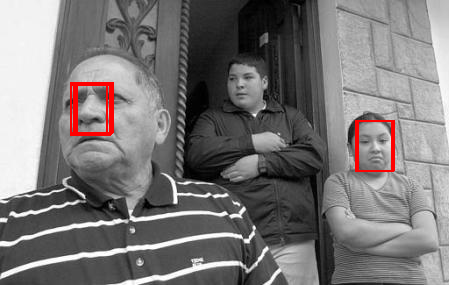

In [11]:
# family
familyPyramid = MakeGaussianPyramid("Image/Part1/family.jpg", 0.75, 30)
FindTemplate(familyPyramid,"Image/Part1/template.jpg",goodThreshold)

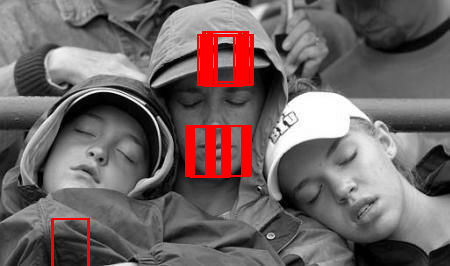

In [12]:
# fans
fansPyramid = MakeGaussianPyramid("Image/Part1/fans.jpg", 0.75, 30)
FindTemplate(fansPyramid,"Image/Part1/template.jpg",goodThreshold)

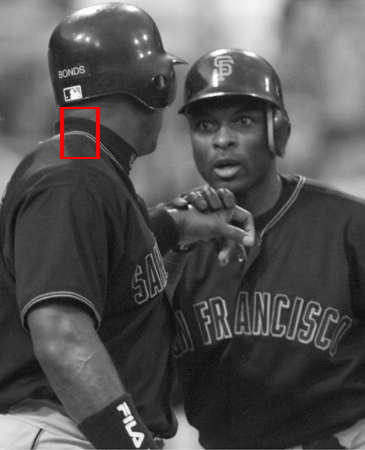

In [13]:
# sports
sportsPyramid = MakeGaussianPyramid("Image/Part1/sports.jpg", 0.75, 30)
FindTemplate(sportsPyramid,"Image/Part1/template.jpg",goodThreshold)

## Part2: Image Blending

### 2. MakeLaplacianPyramid(image, scale, minsize)

In [14]:
def MakeLaplacianPyramid(image: str, scale: float, minsize: int):
    # Step1: Initialize Laplacian pyramid
    LaplacianPyramid = []
    # Step2: Create Gaussian Pyramid
    GaussianPyramid = MakeGaussianPyramid(image, scale, minsize)

    # Step3: Find image width and height
    height = GaussianPyramid[0][0].shape[0]
    width = GaussianPyramid[0][0].shape[1]

    # Step4: Initialize i
    i = 0
    while (height >= minsize and width >= minsize and i < len(GaussianPyramid)-1):
        # Step5: make RGB channels
        RedChannel = GaussianPyramid[i][0]
        GreenChannel = GaussianPyramid[i][1]
        BlueChannel = GaussianPyramid[i][2]

        # Step6: convert RGB channels into float32
        RedChannel = RedChannel.astype(np.float32)
        GreenChannel = GreenChannel.astype(np.float32)
        BlueChannel = BlueChannel.astype(np.float32)

        # Step7: make Blurred channel
        std = 1/(2*scale)
        BlurredRedChannel = ndimage.gaussian_filter(RedChannel, sigma=std)
        BlurredGreenChannel = ndimage.gaussian_filter(GreenChannel, sigma=std)
        BlurredBlueChannel = ndimage.gaussian_filter(BlueChannel, sigma=std)

        # Step8: convert blurred RGB channels into float32
        BlurredRedChannel = BlurredRedChannel.astype(np.float32)
        BlurredGreenChannel = BlurredGreenChannel.astype(np.float32)
        BlurredBlueChannel = BlurredBlueChannel.astype(np.float32)

        # Step9: Gaussian channel - Blurred channel
        LaplacianRedChannel = RedChannel - BlurredRedChannel
        LaplacianGreenChannel = GreenChannel - BlurredGreenChannel
        LaplacianBlueChannel = BlueChannel - BlurredBlueChannel

        # Step10: Put it to Laplacian pyramid
        LaplacianPyramid.append(
            [LaplacianRedChannel, LaplacianGreenChannel, LaplacianBlueChannel])
        # Step11: increment i
        i = i+1

    # Step12: append last image of Gaussian pyramid
    LaplacianPyramid.append(GaussianPyramid[len(GaussianPyramid)-1])

    # Step13: Blur image
    return LaplacianPyramid

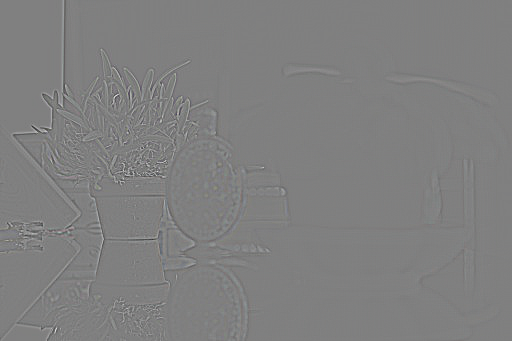

In [15]:
# Step1: Laplacian pyramid for orchid image
orchidLaplacianPyramid = MakeLaplacianPyramid(
    "Image/Part2/orchid.jpg", 0.5, 10)

# Step2: Get RGB channels of the first image in Laplacian pyramid
firstImageRedChannel = orchidLaplacianPyramid[0][0]
firstImageGreenChannel = orchidLaplacianPyramid[0][1]
firstImageBlueChannel = orchidLaplacianPyramid[0][2]

# Step3: Add 128 to each channels so that there are no negative pixel values
firstImageRedChannel = firstImageRedChannel + 128
firstImageGreenChannel = firstImageGreenChannel + 128
firstImageBlueChannel = firstImageBlueChannel + 128

# Step4: Convert RGB channels into uint8, because uint8 is the default data type for Image
firstImageRedChannel = firstImageRedChannel.astype(np.uint8)
firstImageGreenChannel = firstImageGreenChannel.astype(np.uint8)
firstImageBlueChannel = firstImageBlueChannel.astype(np.uint8)

# Step5: Make RGB channels into image
firstImageRedChannel = Image.fromarray(firstImageRedChannel).convert('L')
firstImageGreenChannel = Image.fromarray(firstImageGreenChannel).convert('L')
firstImageBlueChannel = Image.fromarray(firstImageBlueChannel).convert('L')

# Step6: Merge RGB channels into image
orchidLaplacianPyramidImage = Image.merge(
    'RGB', (firstImageRedChannel, firstImageGreenChannel, firstImageBlueChannel))
# orchidLaplacianPyramidImage.show()
orchidLaplacianPyramidImage

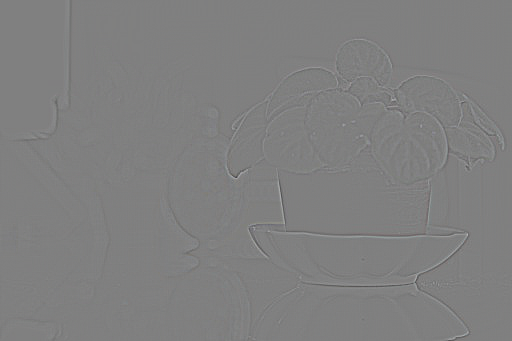

In [16]:
# Step1: Laplacian pyramid for orchid image
violetLaplacianPyramid = MakeLaplacianPyramid(
    "Image/Part2/violet.jpg", 0.5, 10)

# Step2: Get RGB channels of the first image in Laplacian pyramid
firstImageRedChannel = violetLaplacianPyramid[0][0]
firstImageGreenChannel = violetLaplacianPyramid[0][1]
firstImageBlueChannel = violetLaplacianPyramid[0][2]

# Step3: Add 128 to each channels so that there are no negative pixel values
firstImageRedChannel = firstImageRedChannel + 128
firstImageGreenChannel = firstImageGreenChannel + 128
firstImageBlueChannel = firstImageBlueChannel + 128

# Step4: Convert RGB channels into uint8, because uint8 is the default data type for Image
firstImageRedChannel = firstImageRedChannel.astype(np.uint8)
firstImageGreenChannel = firstImageGreenChannel.astype(np.uint8)
firstImageBlueChannel = firstImageBlueChannel.astype(np.uint8)

# Step5: Make RGB channels into image
firstImageRedChannel = Image.fromarray(firstImageRedChannel).convert('L')
firstImageGreenChannel = Image.fromarray(firstImageGreenChannel).convert('L')
firstImageBlueChannel = Image.fromarray(firstImageBlueChannel).convert('L')

# Step6: Merge RGB channels into image
violetLaplacianPyramidImage = Image.merge(
    'RGB', (firstImageRedChannel, firstImageGreenChannel, firstImageBlueChannel))
# violetLaplacianPyramidImage.show()
violetLaplacianPyramidImage

### 3. ShowLaplacianPyramid(pyramid)

In [17]:
def ShowLaplacianPyramid(pyramid):
    # Step1 Calculate number of images
    numberOfImages = len(pyramid)
    for i in range(numberOfImages-1):
        # Step2: declare RGB channels
        RedChannel = pyramid[i][0]
        GreenChannel = pyramid[i][1]
        BlueChannel = pyramid[i][2]
        # Step3: add 128 to RGB channels
        RedChannel += 128  # Red channel
        GreenChannel += 128  # Green channel
        BlueChannel += 128  # Blue channel

    # Step4: convert each RGB Channels of Laplacian pyramid into uint8
        RedChannel = RedChannel.astype(np.uint8)
        GreenChannel = GreenChannel.astype(np.uint8)
        BlueChannel = BlueChannel.astype(np.uint8)
    # Step5: Run showGaussianPyramid function
        laplacianPyramidImage = showGaussianPyramid(pyramid)
    return laplacianPyramidImage

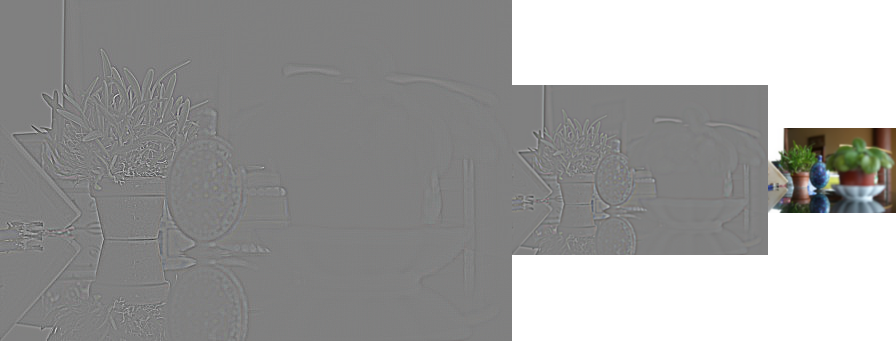

In [18]:
# Orchid laplacian pyramid
orchidPyramid = MakeLaplacianPyramid("Image/Part2/orchid.jpg", 0.5, 100)
orchidPyramidImage = ShowLaplacianPyramid(orchidPyramid)
# orchidPyramidImage.show()
orchidPyramidImage

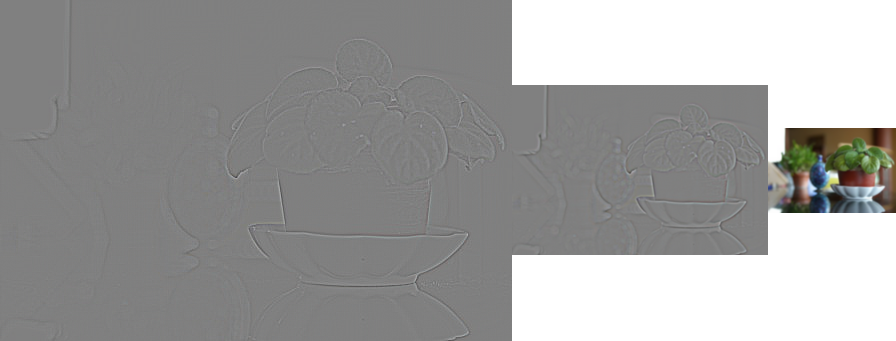

In [19]:
# Violet laplacian pyramid
violetPyramid = MakeLaplacianPyramid("Image/Part2/violet.jpg", 0.5, 100)
violetPyramidImage = ShowLaplacianPyramid(violetPyramid)
# violetPyramidImage.show()
violetPyramidImage

### 4. ReconstructGaussianFromLaplacianPyramid(lPyramid) -> [[np.ndarray, np.ndarray, np.ndarray]]

In [20]:
def ReconstructGaussianFromLaplacianPyramid(lPyramid) -> [[np.ndarray, np.ndarray, np.ndarray]]:
    # Step1: Initialize Gaussian pyramid to be recovered
    recoveredGaussianPyramid = []
    # Step2: prepend last image of Laplacian pyramid to Gaussian pyramid
    numberOfImage = len(lPyramid)
    recoveredGaussianPyramid.insert(0, lPyramid[numberOfImage-1])

    # Index is counted from back to the beginning
    for i in range(numberOfImage-1, 0, -1):
        # Step3: assign into RGB channels
        RedChannel = Image.fromarray(
            recoveredGaussianPyramid[0][0]).convert('L')
        GreenChannel = Image.fromarray(
            recoveredGaussianPyramid[0][1]).convert('L')
        BlueChannel = Image.fromarray(
            recoveredGaussianPyramid[0][2]).convert('L')
        # current data type: PIL.Image.Image

        # Step4: resize to be the same as Laplacian pyramid at that level
        RedChannel = RedChannel.resize(
            (lPyramid[i-1][0].shape[1], lPyramid[i-1][0].shape[0]), Image.BICUBIC)
        GreenChannel = GreenChannel.resize(
            (lPyramid[i-1][0].shape[1], lPyramid[i-1][0].shape[0]), Image.BICUBIC)
        BlueChannel = BlueChannel.resize(
            (lPyramid[i-1][0].shape[1], lPyramid[i-1][0].shape[0]), Image.BICUBIC)

        # Step5: convert channels back to numpy array
        RedChannel = np.asarray(RedChannel)
        GreenChannel = np.asarray(GreenChannel)
        BlueChannel = np.asarray(BlueChannel)

        # Step6: convert RGB channels into float32
        RedChannel = RedChannel.astype(np.float32)
        GreenChannel = GreenChannel.astype(np.float32)
        BlueChannel = BlueChannel.astype(np.float32)

        # Step7: Assign laplacian pyramid channels
        laplacianRedChannel = lPyramid[i-1][0]
        laplacianGreenChannel = lPyramid[i-1][1]
        laplacianBlueChannel = lPyramid[i-1][2]

        # Step8: add Channels into Laplacian image at that level
        GaussianRedChannel = RedChannel + laplacianRedChannel
        GaussianGreenChannel = GreenChannel + laplacianGreenChannel
        GaussianBlueChannel = BlueChannel + laplacianBlueChannel

        # Step9: clip RGB channels to [0,255]
        GaussianRedChannel = np.clip(GaussianRedChannel, 0, 255)
        GaussianGreenChannel = np.clip(GaussianGreenChannel, 0, 255)
        GaussianBlueChannel = np.clip(GaussianBlueChannel, 0, 255)

        # Step10: convert RGB channels into uint8
        GaussianRedChannel = GaussianRedChannel.astype(np.uint8)
        GaussianGreenChannel = GaussianGreenChannel.astype(np.uint8)
        GaussianBlueChannel = GaussianBlueChannel.astype(np.uint8)

        # Step11: prepend to the recovered Gaussian list
        recoveredGaussianPyramid.insert(
            0, [GaussianRedChannel, GaussianGreenChannel, GaussianBlueChannel])

    return recoveredGaussianPyramid

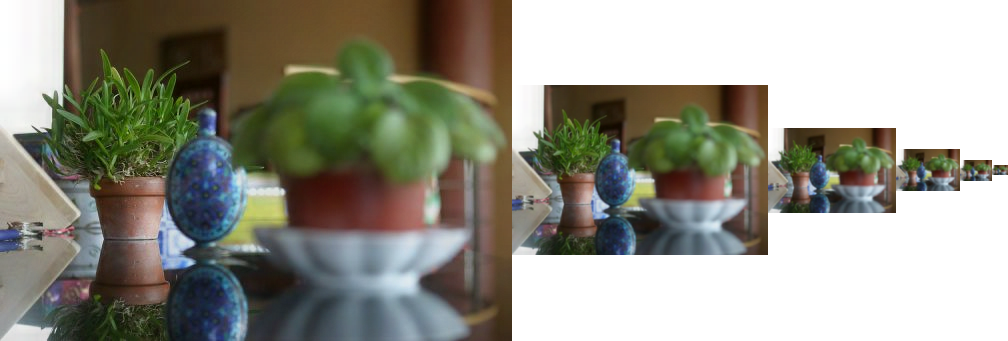

In [21]:
# Gaussian pyramid of orchid, reconstructed from Laplacian pyramid
orchidLaplacianPyramid = MakeLaplacianPyramid(
    "Image/Part2/orchid.jpg", 0.5, 10)
orchidGaussianPyramid = ReconstructGaussianFromLaplacianPyramid(
    orchidLaplacianPyramid)
reconstructedOrchidGaussianPyramidImage = showGaussianPyramid(
    orchidGaussianPyramid)
# reconstructedOrchidGaussianPyramidImage.show()
reconstructedOrchidGaussianPyramidImage

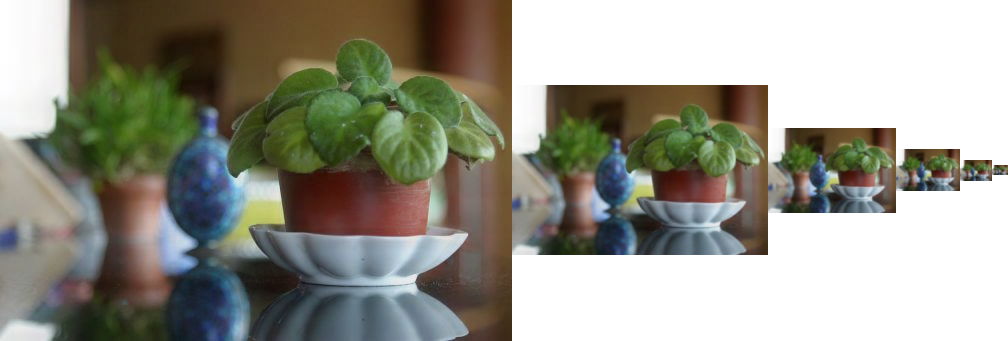

In [22]:
# Gaussian pyramid of violet, reconstructed from Laplacian pyramid
violetLaplacianPyramid = MakeLaplacianPyramid(
    "Image/Part2/violet.jpg", 0.5, 10)
violetGaussianPyramid = ReconstructGaussianFromLaplacianPyramid(
    violetLaplacianPyramid)
reconstructedVioletGaussianPyramidImage = showGaussianPyramid(
    violetGaussianPyramid)
# reconstructedVioletGaussianPyramidImage.show()
reconstructedVioletGaussianPyramidImage

### 5. orchard_mask.bmp

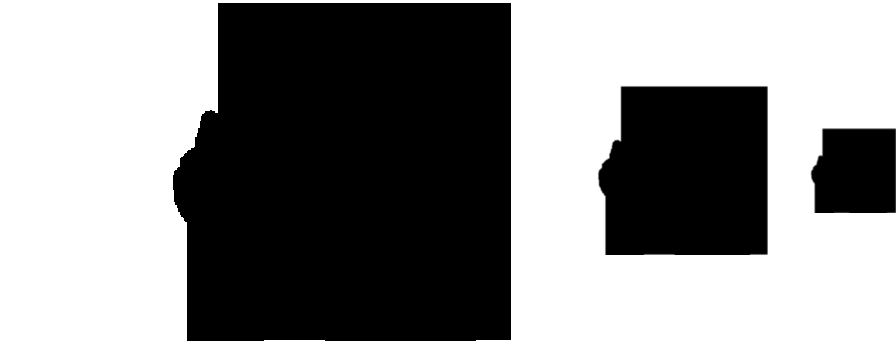

In [23]:
# Gaussian pyramid of mask
orchidMaskPyramid = MakeGaussianPyramid(
    "Image/Part2/orchid_mask.bmp", 0.5, 100)

maskGaussianPyramid = showGaussianPyramid(orchidMaskPyramid)
# maskGaussianPyramid.show()
maskGaussianPyramid

### 6. Image blending
* orchid + violet

In [24]:
def blendTwoImages(imageA: str, imageB: str, mask: str):
    MinimumSize = 1
    # Step1: Make Laplacian pyramid of orchid and violet
    lapA = MakeLaplacianPyramid(imageA, 0.5, MinimumSize)
    lapB = MakeLaplacianPyramid(imageB, 0.5, MinimumSize)

    # Step2: Make Gaussian pyramid of orchid_mask.bmp
    gaussianM = MakeGaussianPyramid(mask, 0.5, MinimumSize)

    # Step3: Count the length of pyramid
    numberOfImage = len(lapA)

    # Step4: Initialize Blended pyramid
    output = [1]*numberOfImage

    for i in range(numberOfImage):
        # Step5: Channels of Image A
        RedLaplacianChannelA = lapA[i][0]
        GreenLaplacianChannelA = lapA[i][1]
        BlueLaplacianChannelA = lapA[i][2]

        # Step6: Channels of Image B
        RedLaplacianChannelB = lapB[i][0]
        GreenLaplacianChannelB = lapB[i][1]
        BlueLaplacianChannelB = lapB[i][2]

        # Step7: Channels of mask
        RedChannelMask = gaussianM[i][0]
        GreenChannelMask = gaussianM[i][1]
        BlueChannelMask = gaussianM[i][2]

        # Step8: convert mask into float32
        RedChannelMask = RedChannelMask.astype(np.float32)
        GreenChannelMask = GreenChannelMask.astype(np.float32)
        BlueChannelMask = BlueChannelMask.astype(np.float32)

        # step9: Use given formula in the assignment instruction
        BlendedRedChannel = RedLaplacianChannelA * \
            RedChannelMask/255.+RedLaplacianChannelB*(1-RedChannelMask/255.)
        BlendedGreenChannel = GreenLaplacianChannelA * \
            GreenChannelMask/255.+GreenLaplacianChannelB * \
            (1-GreenChannelMask/255.)
        BlendedBlueChannel = BlueLaplacianChannelA * \
            BlueChannelMask/255.+BlueLaplacianChannelB*(1-BlueChannelMask/255.)

        # Step10: combine blended RGB channels into one array
        output[i] = [BlendedRedChannel, BlendedGreenChannel, BlendedBlueChannel]

    return output

* Orchid blended with violet

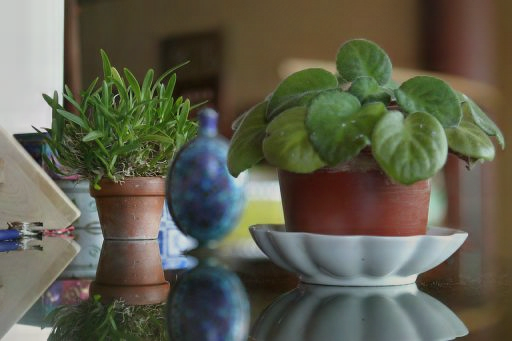

In [25]:
# Orchid and violet blended image
blendedPyramid = blendTwoImages("Image/Part2/orchid.jpg", "Image/Part2/violet.jpg",
                                "Image/Part2/orchid_mask.bmp")

blendedPyramid = ReconstructGaussianFromLaplacianPyramid(blendedPyramid)
orchidVioletBlendedImage = showGaussianPyramid([blendedPyramid[0]])
# orchidVioletBlendedImage.show()
orchidVioletBlendedImage

### 7. Experiment

* Blue cup blended with green cup

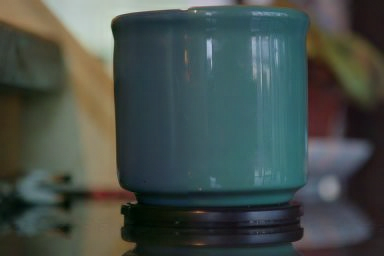

In [26]:
# Blue cup and green cup blended image
blendedPyramid = blendTwoImages(
    "Image/Part2/blue_cup.jpg", "Image/Part2/green_cup.jpg", "Image/Part2/cup_mask.bmp")
blendedPyramid = ReconstructGaussianFromLaplacianPyramid(blendedPyramid)
blueCupRedCupBlendedImage = showGaussianPyramid([blendedPyramid[0]])
# blueCupRedCupBlendedImage.show()
blueCupRedCupBlendedImage

* Apple blended with tomato

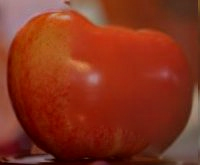

In [27]:
# Apple and tomato blended image
blendedPyramid = blendTwoImages(
    "Image/Part2/apple.jpg", "Image/Part2/tomato.jpg", "Image/Part2/tomato_mask.bmp")
blendedPyramid = ReconstructGaussianFromLaplacianPyramid(blendedPyramid)
appleTomatoBlendedImage = showGaussianPyramid([blendedPyramid[0]])
# appleTomatoBlendedImage.show()
appleTomatoBlendedImage